In [1]:
import CMR_HFpEF_Analysis.Defaults as Defaults
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util
import CMR_HFpEF_Analysis.HFpEF_data_analysis.other_tools.json_template as json_template

import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import json
import shutil
import SimpleITK as sitk
import cv2 

# main_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data/'
main_path = '/mnt/mount_zc_NAS/HFpEF/data/'

# step by step: turn mask to contour

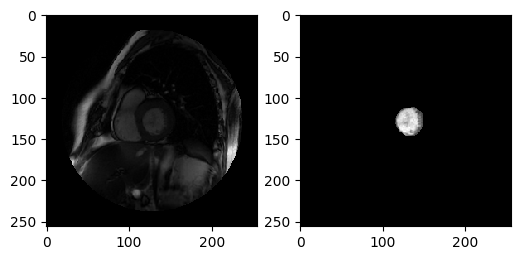

In [23]:
# load image
img = nb.load(os.path.join(main_path,'sunnybrooks_nii/SC-N-09', 'SAX_ED.nii.gz')).get_fdata()[:, :, ::-1]
endo = nb.load(os.path.join(main_path,'sunnybrooks_nii/SC-N-09', 'SAX_ED_endo.nii.gz')).get_fdata()[:,:,::-1]
# epi = nb.load(os.path.join(main_path,'sunnybrooks_nii/SC-N-3', 'SAX_ED_epi.nii.gz')).get_fdata()[:,:,::-1]
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(np.flip(img[:,:,0].T,0), 'gray')
plt.subplot(122); plt.imshow(np.flip(endo[:,:,0].T,0), 'gray')

In [24]:
# make categorical segmentation
mask = np.zeros_like(img)
# mask[epi>0] = 2
mask[endo>0] = 1

# move LV center to the image center
center_mass = util.center_of_mass(mask[:,:, mask.shape[-1]//2],1,large = False)
center_image = [ int(mask.shape[i] // 2) for i in range(0,len(mask.shape))]
mask = util.move_3Dimage(mask, [center_image[0] - int(center_mass[0]) , center_image[1] - int(center_mass[1]), 0] )

mask = util.crop_or_pad(mask, [128,128, mask.shape[-1]])


In [25]:
# convert mask to contour
contour_point_positions = []
for slice_n in range(0,mask.shape[-1]):
    cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo', 'Epi'], [1,2])

    for name in ['Endo']:
        if type(cts_dict[name]) is type(None):
            continue

        # sample the points
        sample_rate = cts_dict[name].shape[0] // (cts_dict[name].shape[0] // 2)
        if sample_rate > 0:
            pts = cts_dict[name][::sample_rate]
        else:
            pts = cts_dict[name]
                
        for i in range(0, pts.shape[0]):
            contour_point_positions.append([pts[i][1], pts[i][0], slice_n])
contour_point_positions = np.asarray(contour_point_positions)

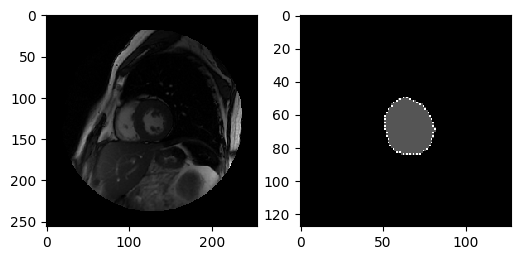

In [26]:
mask_endo = np.copy(mask)
mask_endo[contour_point_positions[:,0], contour_point_positions[:,1], contour_point_positions[:,2]] = 3

plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(np.flip(img[:,:,2].T,0), 'gray')
plt.subplot(122); plt.imshow(np.flip(mask_endo[:,:,2].T,0), 'gray')

project contours on 2D plane

[0, 1] [2, 3] [4, 5, 6, 7]


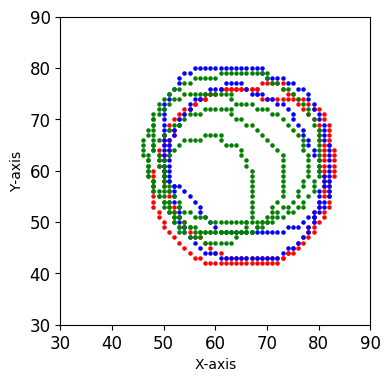

In [27]:
lv_slice = [i for i in range(0, mask.shape[-1]) if np.where(mask[:,:,i] == 1)[0].shape[0] != 0]
k = len(lv_slice) // 3
base = lv_slice[:k]
mid = lv_slice[k : 2*k]
apex = lv_slice[2*k:]
print(base, mid, apex)

plt.figure(figsize = (4,4))
color_list = ['red','blue', 'green']

for ss in range(0, len(lv_slice)):
    slice_n = lv_slice[ss]
          
    if slice_n in base:
        color = color_list[0]
    elif slice_n in mid:
        color = color_list[1]
    else:
        color = color_list[2]
        
    cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo'], [1])
    plt.scatter(cts_dict['Endo'][:,1], cts_dict['Endo'][:,0], s = 5, c = color)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xticks(np.arange(30,91,step = 10),fontsize=12)
plt.yticks(np.arange(30,91,step = 10),fontsize=12)

plt.savefig(os.path.join(main_path,'SC-N-09.png'))
            
           

In [ ]:
lv_slice = [i for i in range(0, mask.shape[-1]) if np.where(mask[:,:,i] == 1)[0].shape[0] != 0]
k = len(lv_slice) // 3
base = lv_slice[:k]
mid = lv_slice[k : 2*k]
apex = lv_slice[2*k:]

    # # move LV center into the image center 
    center_mass = util.center_of_mass(mask[:,:, lv_slice[int(slice_num//2)]],1,large = False)
    center_image = [ int(mask.shape[i] // 2) for i in range(0,len(mask.shape))]
    mask = util.move_3Dimage(mask, [center_image[0] - int(center_mass[0]) , center_image[1] - int(center_mass[1]), 0] )

    # crop (for our data)
    mask = util.crop_or_pad(mask,[128,128, mask.shape[-1]])

    # flip in y-axis (for our data)
    mask = np.flip(mask, 1)


    # plot
    plt.figure(figsize = (4,4))
    color_list = ['red','blue', 'green']
    structure_list = ['Endo']
    for structure in structure_list:
        for ss in range(0, len(lv_slice)):
            slice_n = lv_slice[ss]
            cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo'], [1])

            if slice_n in base:
                color = color_list[0]
            elif slice_n in mid:
                color = color_list[1]
            else:
                color = color_list[2]
            plt.scatter(cts_dict[structure][:,0], cts_dict[structure][:,1], s = 5, c = color)

            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            
            if structure[0:2] == 'En':
                plt.xticks(np.arange(30,91,step = 10),fontsize=12)
                plt.yticks(np.arange(30,91,step = 10),fontsize=12)
            else:
                plt.xticks(np.arange(30,91,step = 10),fontsize=12)
                plt.yticks(np.arange(30,91,step = 10),fontsize=12)

            # save_path = os.path.join(main_path, 'normal', patient_id, tf +'_' + structure +'.png')
            save_path = os.path.join(os.path.dirname(patient), tf +'_' + structure +'.png')
            # ff.make_folder([os.path.join(main_path, 'normal', patient_id)])
            plt.savefig(save_path)



# main script: Turn mask to contour and save in json file

In [7]:
# define patients:
patients = ff.find_all_target_files(['ID_0001'],os.path.join(main_path,'AI_seg'))

for patient in patients:

    patient_id = os.path.basename(patient)

    # get ED and ES
    edes_file = os.path.join(main_path, 'ED_ES', patient_id,'ED_ES.txt')
    with open(edes_file, 'r') as file:
        line = file.readline().strip().split()
        ed = int(line[0])
        es = int(line[1])
    tf = [ed, es]

    for tf_i in range(0,len(tf)):
        if tf_i == 0:
            current_t = 'ED'
        else:
            current_t = 'ES'

        save_folder = os.path.join(main_path, 'contours', patient_id, 'AI_contours')
        ff.make_folder([os.path.dirname(save_folder), save_folder])
        
        tf_folder = os.path.join(patient, 'Org3D_frame' + str(tf[tf_i]))

        # copy 
        if os.path.isdir(os.path.join(save_folder, 'ai_Org3D_frame' + str(tf[tf_i])) )== 0:
            shutil.copytree(tf_folder,os.path.join(save_folder, 'ai_Org3D_frame' + str(tf[tf_i])))

        # load mask by AI
        mask_file = nb.load(os.path.join(tf_folder, 'mask.nii.gz'))
        mask = mask_file.get_fdata()
        # switch class so LV = 1, Myo = 2, RV = 3
        mask = ff.switch_class(mask,1,3)
        # get total slice num
        slice_num = mask.shape[-1]

        for slice_n in range(0, slice_num):
            # get contour points
            cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo', 'Epi', 'RV'], [1,2,3])


            for name in ['Endo','Epi', 'RV']:
                contour_point_positions = []
                if type(cts_dict[name]) is type(None):
                    continue

                # sample the points
                sample_rate = cts_dict[name].shape[0] // 12
                if sample_rate > 0:
                    pts = cts_dict[name][::sample_rate]
                else:
                    pts = cts_dict[name]
             
                for i in range(0, pts.shape[0]):
                    contour_point_positions.append([-pts[i][1], -pts[i][0], slice_n])
                
                # save in json file 
                if name[0:2] == 'En':
                    color_code = [1.0, 0.13333333333333334, 0.054901960784313728]
                elif name[0:2] == 'Ep':
                    color_code = [1.0, 1.0, 0.3686274509803922]
                else:
                    color_code = [0.09411764705882353, 0.25882352941176475, 1.0]

                json_data = json_template.json_template(contour_point_positions, color_code)
                
                save_folder_sub = os.path.join(save_folder, 'ai_'+ current_t); ff.make_folder([save_folder_sub])
                filename = os.path.join(save_folder_sub, name+'_slice_'+str(slice_n)+'.json')

                with open(filename, "w") as f:
                    # write the data as a JSON string to the file
                    json.dump(json_data, f)

/home/zc13/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Main Script: Turn control points (in json file) into a mask

In [79]:
case_list = ff.find_all_target_files(['ID_0128'], os.path.join(main_path, 'img'))

for case in case_list:

    patient_id = os.path.basename(case)

    # find all frames
    frame_list = ff.sort_timeframe(ff.find_all_target_files(['*frame1*'],case),1,'e')

    # put the mid slice from each frame into a new image
    for i in range(0,frame_list.shape[0]):
        frame = sitk.ReadImage(frame_list[i])
        spacing = frame.GetSpacing()
        img = np.rollaxis(sitk.GetArrayFromImage(frame),0,3)
        img = np.rollaxis(img,0,2)
        
        

        nb.save(nb.Nifti1Image(np.flip(np.flip(img,0),1), np.eye(4)), os.path.join(main_path, 'dd.nii.gz'))

In [85]:
case_list = ff.find_all_target_files(['ID_0128'], os.path.join(main_path, 'contours'))

for case in case_list:

    patient_id = os.path.basename(case)

    # load image
    img_file = os.path.join(main_path, 'img', patient_id, 'Org3D_frame1.nrrd')
    img = sitk.ReadImage(img_file)
    spacing = img.GetSpacing()
    img = np.rollaxis(sitk.GetArrayFromImage(img),0,3)
    img = np.rollaxis(img,0,2)

    # contour folder
    contour_folder = os.path.join(case, 'manual_contours')


    # find all contour files
    endo_files = ff.sort_timeframe(ff.find_all_target_files(['Endo*'],contour_folder),1,'_')
    epi_files = ff.sort_timeframe(ff.find_all_target_files(['Epi*'],contour_folder),1,'_')

    assert len(endo_files) == len(epi_files)
    
    # final segmentation
    seg = np.zeros(img.shape)

    for file_i in range(0,len(endo_files)):
        slice_index = ff.find_timeframe(endo_files[file_i], 1, '_')
        
        endo_pts = []; epi_pts = []

        # get endo and epi contour points
        with open(endo_files[file_i], 'r') as f:
            endo_data = json.load(f)
        endo_data = endo_data['markups'][0]['controlPoints']
        for l in range(0,len(endo_data)):
            # if it's manual drawing from 3D slicer, need to convert from mm to pixel unit
            endo_pts.append([endo_data[l]['position'][1] / spacing[0], endo_data[l]['position'][0] / spacing[1]])

        with open(epi_files[file_i], 'r') as f:
            epi_data = json.load(f)
        epi_data = epi_data['markups'][0]['controlPoints']
        for l in range(0,len(epi_data)):
            # if it's manual drawing from 3D slicer, need to convert from mm to pixel unit
            epi_pts.append([epi_data[l]['position'][1] / spacing[0], epi_data[l]['position'][0] / spacing[1]])

        cts_dict = {"Endo":np.asarray(endo_pts).astype(int), "Epi": np.asarray(epi_pts).astype(int), "RV": None}

        seg[:,:,slice_index] = util.contourpts_to_mask(cts_dict, np.zeros([img.shape[0], img.shape[1]]),  ['LV', 'Myo'], [1,2], sample_rate = 1)
      

# Turn mask into control points of contours

(256, 256, 16) (1.0, 1.0, 8)


/tmp/ipykernel_2471353/4183633093.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = mask_file.get_data()


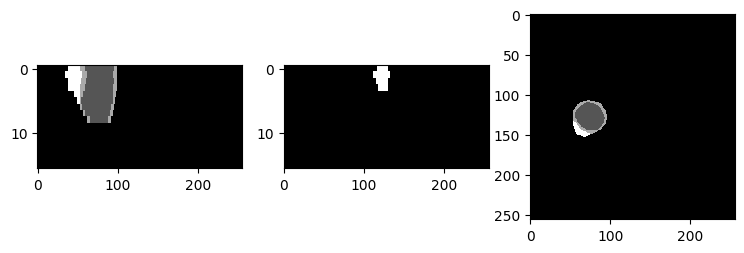

In [36]:
# load mask
mask_file = nb.load(os.path.join(main_path, '060_ED_mask.nii.gz'))
spacing = (1.0, 1.0, 8)
mask = mask_file.get_data()

mask = ff.switch_class(mask,1,3)

print(mask.shape,spacing)

plt.figure(figsize = (9,3))
plt.subplot(131); plt.imshow(mask[mask.shape[0]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(mask[:,mask.shape[1]//2-30, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(mask[:,:,6], 'gray', aspect=spacing[0] / spacing[1])


In [37]:
# convert mask to contours
slice_n = 5
cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo', 'Epi', 'RV'], [1,2,3])


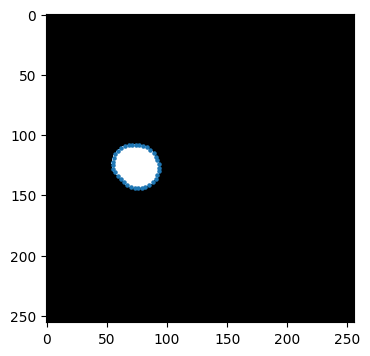

In [4]:
plt.figure(figsize = (4,4))
plt.imshow(mask[:,:,slice_n]==1, 'gray')
plt.scatter(cts_dict['Endo'][:,0][::3], cts_dict['Endo'][:,1][::3], s = 5)


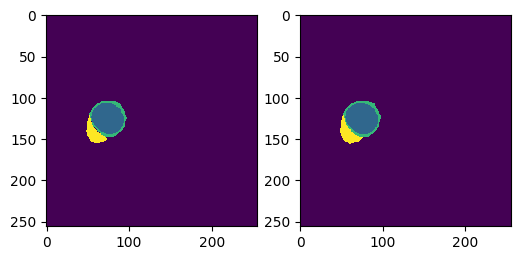

In [5]:
final_img = util.contourpts_to_mask(cts_dict,mask[:,:,slice_n], ['LV', 'Myo', 'RV'], [1,2,3],5)
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(final_img)
plt.subplot(122); plt.imshow(mask[:,:,slice_n])

# Generate the json file

In [9]:
# generate for LV endo
L = []
pts = cts_dict['Endo'][::8]
for i in range(0, pts.shape[0]):
    L.append([-pts[i][1], -pts[i][0], slice_n])

print(L)


[[-108, -68, 5], [-112, -60, 5], [-120, -55, 5], [-128, -55, 5], [-135, -61, 5], [-142, -68, 5], [-144, -76, 5], [-142, -84, 5], [-135, -92, 5], [-127, -93, 5], [-119, -91, 5], [-111, -85, 5], [-108, -77, 5], [-108, -69, 5]]


In [10]:
data = {
    "@schema": "https://raw.githubusercontent.com/slicer/slicer/master/Modules/Loadable/Markups/Resources/Schema/markups-schema-v1.0.3.json#",
    "markups": [
        {
            "type": "ClosedCurve",
            "coordinateSystem": "LPS",
            "coordinateUnits": "mm",
            "locked": False,
            "fixedNumberOfControlPoints": False,
            "labelFormat": "%N-%d",
            "lastUsedControlPointNumber": len(L),
            "controlPoints": [
                {
                    "id": str(i+1),
                    "label": "CC_{}".format(i+1),
                    "description": "",
                    "associatedNodeID": "vtkMRMLScalarVolumeNode1",
                    "position": [float(xx) for xx in L[i]],
                    "orientation": [-1.0, -0.0, -0.0, -0.0, -1.0, -0.0, 0.0, 0.0, 1.0],
                    "selected": True,
                    "locked": False,
                    "visibility": True,
                    "positionStatus": "defined"
                } for i in range(len(L))
            ],
            "measurements": [
                {
                    "name": "length",
                    "enabled": False,
                    "units": "mm",
                    "printFormat": "%-#4.4g%s"
                },
                {
                    "name": "curvature mean",
                    "enabled": False,
                    "printFormat": "%5.3f %s"
                },
                {
                    "name": "curvature max",
                    "enabled": False,
                    "printFormat": "%5.3f %s"
                },
                {
                    "name": "area",
                    "enabled": False,
                    "units": "cm2",
                    "printFormat": "%-#4.4g%s"
                }
            ],
            "display": {
                "visibility": True,
                "opacity": 1.0,
                "color": [0.4, 1.0, 0.0],
                "selectedColor": [1.0, 0.5000076295109484, 0.5000076295109484],
                "activeColor": [0.4, 1.0, 0.0],
                "propertiesLabelVisibility": True,
                "pointLabelsVisibility": False,
                "textScale": 3.0,
                "glyphType": "Sphere3D",
                "glyphScale": 3.0,
                "glyphSize": 5.0,
                "useGlyphScale": True,
                "sliceProjection": False,
                "sliceProjectionUseFiducialColor": True,
                "sliceProjectionOutlinedBehindSlicePlane": False,
                "sliceProjectionColor": [1.0, 1.0, 1.0],
                "sliceProjectionOpacity": 0.6,
                "lineThickness": 0.2,
                "lineColorFadingStart": 1.0,
                "lineColorFadingEnd": 10.0,
                "lineColorFadingSaturation": 1.0,
                "lineColorFadingHueOffset": 0.0,
                "handlesInteractive": False,
                "translationHandleVisibility": True,
                "rotationHandleVisibility": True,
                "scaleHandleVisibility": True,
                "scaleHandleVisibility": True,
                "interactionHandleScale": 3.0,
                "snapMode": "toVisibleSurface"
            }
        }
    ]
}

In [11]:
filename = os.path.join(main_path,'j.json')
with open(filename, "w") as f:
    # write the data as a JSON string to the file
    json.dump(data, f)

# read a json file

In [17]:
with open(filename, 'r') as f:
    data = json.load(f)
a = data['markups']

In [22]:
print(a[0]['controlPoints'][0]['position'])

[-108.0, -68.0, 5.0]


# Generate images with contours projected on a 2D plane

In [81]:
# data_path = '/mnt/mount_zc_NAS/HFpEF/data/simulated_data_version2/'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data/'
main_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data/'

# patient_list = ff.sort_timeframe(ff.find_all_target_files(['3'],data_path),0)
# case_list = []
# for p in patient_list:
#     cases = ff.find_all_target_files(['ED'],p)
#     for c in cases:
#         case_list.append(c)

case_list = ff.find_all_target_files(['ID_0024/*'], os.path.join(data_path, 'HFpEF'))

patient_list = case_list[0:1]

In [82]:
for patient in patient_list:
    patient_id = os.path.basename(os.path.dirname(patient))
    tf = os.path.basename(patient)

    print(patient_id, tf)

    # mask_file = nb.load(os.path.join(patient, 'ds/data_flip_clean.nii.gz'))

    mask_file = nb.load(os.path.join(patient, 'ED_Endo.nii.gz'))
    spacing = mask_file.header.get_zooms()
    
    mask = mask_file.get_data()
    mask = np.round(mask)

    # mask2 = nb.load(os.path.join(patient, 'ED_RV.nii.gz')).get_data()
    # mask[np.round(mask2) == 1] = 3
                                    
    mask = util.relabel(mask, 4, 3)

    # mask =  mask[:,:,[mask.shape[-1] - i for i in range(1,mask.shape[-1] + 1)]]

    # seperate base, mid and apex
    lv_slice = [i for i in range(0, mask.shape[-1]) if np.where(mask[:,:,i] == 1)[0].shape[0] != 0]
    slice_num = len(lv_slice)
    k = len(lv_slice) // 3
    base = lv_slice[:k]
    mid = lv_slice[k : 2*k]
    apex = lv_slice[2*k:]

    # # move LV center into the image center 
    center_mass = util.center_of_mass(mask[:,:, lv_slice[int(slice_num//2)]],1,large = False)
    center_image = [ int(mask.shape[i] // 2) for i in range(0,len(mask.shape))]
    mask = util.move_3Dimage(mask, [center_image[0] - int(center_mass[0]) , center_image[1] - int(center_mass[1]), 0] )

    # crop (for our data)
    mask = util.crop_or_pad(mask,[128,128, mask.shape[-1]])

    # flip in y-axis (for our data)
    mask = np.flip(mask, 1)


    # plot
    plt.figure(figsize = (4,4))
    color_list = ['red','blue', 'green']
    structure_list = ['Endo']
    for structure in structure_list:
        for ss in range(0, len(lv_slice)):
            slice_n = lv_slice[ss]
            cts_dict = util.mask_to_contourpts(mask[:,:,slice_n], ['Endo'], [1])

            if slice_n in base:
                color = color_list[0]
            elif slice_n in mid:
                color = color_list[1]
            else:
                color = color_list[2]
            plt.scatter(cts_dict[structure][:,0], cts_dict[structure][:,1], s = 5, c = color)

            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            
            if structure[0:2] == 'En':
                plt.xticks(np.arange(30,91,step = 10),fontsize=12)
                plt.yticks(np.arange(30,91,step = 10),fontsize=12)
            else:
                plt.xticks(np.arange(30,91,step = 10),fontsize=12)
                plt.yticks(np.arange(30,91,step = 10),fontsize=12)

            # save_path = os.path.join(main_path, 'normal', patient_id, tf +'_' + structure +'.png')
            save_path = os.path.join(os.path.dirname(patient), tf +'_' + structure +'.png')
            # ff.make_folder([os.path.join(main_path, 'normal', patient_id)])
            # plt.savefig(save_path)

